# Ensemble Learning and Random Forests


 A group of predictors is called an **ensemble**; thus, this technique is called **Ensemble Learning**, and an **Ensemble Learning algorithm is called an Ensemble method**.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set.

To make predictions,
+ You just obtain the predictions of all individual trees,
+ then predict the class that gets the most votes.

**Such an ensemble of Decision Trees is called a Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.



## Voting Classifiers

![Training diverse classifiers](images/ensembles/training_diverse_classifiers.png)

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. 
**This majority-vote classifier is called a hard voting classifier**.

![Hard voting classifier classification](images/ensembles/hard_voting.png)


Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble.
+ In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), 
+ provided there are a sufficient number of weak learners and they are sufficiently diverse.

Suppose if all the classifiers trained in the ensemble has a accuracy of 51% only. So to find the combined accuracy we want to find how many times each of the classifiers are correct.

For a binary classifier, running it n times the probability distribution will be the binomial series


**<sup>n</sup>C<sub>r</sub>a<sup>n-r</sup>b<sup>r</sup> **

 where n-r > r ie the power of a is greater than power of b

In [1]:
import numpy as np
def nCr(n, r):
    return np.math.factorial(n)//(np.math.factorial(r) * np.math.factorial(n-r))

In [2]:
nCr(3, 2)

3

In [3]:
prob = 0
from decimal import Decimal
n = 2000
for i in range(1, n//2):
    prob += np.multiply(np.multiply(nCr(n, i), Decimal(0.51 ** (n-i))), Decimal(0.49 ** i))
    
prob 


Decimal('0.8084155213343931223418160014')

#### How is this possible ??

+ Suppose you have a slightly biased coin that has a 51% chance of coming up heads, 
+ and 49% chance of coming up tails. 
+ If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, 
+ and hence a majority of heads. 

If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). 

Below figure shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.


#### Lets prepare with common imports and settings

In [4]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import os

# setting random seed
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


CHAPTER_ID = "ensembles"

def image_path(fig_id):
    
    if os.path.exists(os.path.join("images", CHAPTER_ID)):
        return os.path.join("images", CHAPTER_ID, fig_id)
    os.mkdir(os.path.join("images", CHAPTER_ID))
    return os.path.join("images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [5]:
heads_proba = 0.51 # The probability of head is 0.51 as it is a biased coin

# coin_tosses contains the coin tosses for 10 series of 10000 times of coin tosses
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) 
cumulative_sum_of_number_of_heads = np.cumsum(coin_tosses, axis=0)
cumulative_heads_ratio = cumulative_sum_of_number_of_heads / np.arange(1, 10001).reshape(-1, 1)
cumulative_heads_ratio


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.5       ],
       [0.66666667, 0.33333333, 0.33333333, ..., 0.        , 0.33333333,
        0.66666667],
       ...,
       [0.51140228, 0.5115023 , 0.50680136, ..., 0.5095019 , 0.51070214,
        0.51010202],
       [0.51135114, 0.51145115, 0.50685069, ..., 0.50955096, 0.51075108,
        0.51015102],
       [0.5113    , 0.5115    , 0.5068    , ..., 0.5095    , 0.5108    ,
        0.5102    ]])

#### Now let's visualize that the probability reaches 51 with increasing number of trials

Saving figure law_of_large_numbers_plot


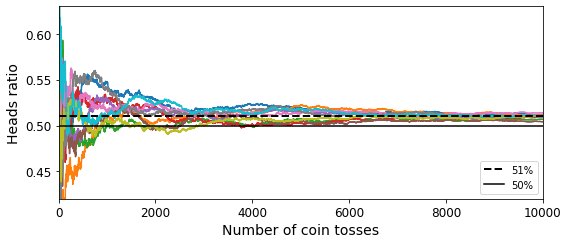

In [6]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.63])
save_fig("law_of_large_numbers_plot")
plt.show()


Ensemble methods work best when the predictors are 

+ As independent from one another as possible. 
+ One way to get diverse classifiers is to train them using very different algorithms. 
+ This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.


Let's train a voting classifier and check if it performs better than the individual classifiers

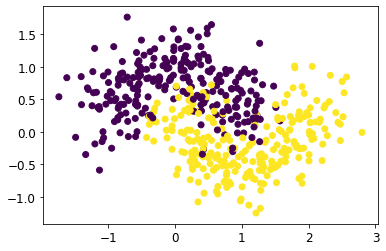

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**The voting classifier slightly outperforms all the individual classifiers.**


## Hard voting and Soft voting

+ If all classifiers are able to **estimate class probabilities (i.e., they have a predict_proba() method)**, then you can tell Scikit-Learn **to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting.**

+ It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities. 

+ This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method). 

Let us modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91% accuracy!

In [10]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [11]:
for (name, prd) in ('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf):
    prd.fit(X_train, y_train)

In [12]:
res = {}
for (name, prd) in ('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf):
    predictions = prd.predict_proba(X_test)
    res[name] = predictions

correct = 0
wrong = 0
for i in range(len(y_test)):
    avgprob = (res['lr'][i] + res['rf'][i] + res['svc'][i])/3
    outcome = 0
    if avgprob[0] < avgprob[1]: 
        outcome = 1
    if outcome == y_test[i]: correct += 1
    else: wrong += 1
print(correct/(correct + wrong))

0.92


In [13]:
res = {}
for (name, prd) in ('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf):
    predictions = prd.predict(X_test)
    res[name] = predictions

correct = 0
wrong = 0
for i in range(len(y_test)):
    outcome = (res['lr'][i] + res['rf'][i] + res['svc'][i]) > 1
    if avgprob[0] < avgprob[1]: 
        outcome = 1
    if outcome == y_test[i]: correct += 1
    else: wrong += 1
print(correct/(correct + wrong))

0.912


In [14]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting

+ One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed.
+ Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. 


+ When sampling **is performed with replacement, this method is called bagging (short for bootstrap aggregating2)**. 
+ When sampling **is performed without replacement, it is called pasting**.


In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor

![Pasting and Bagging](images/ensembles/pasting_bagging.png)

+ Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.
+ The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.


**As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.**

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from **the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False)**.


The n_jobs parameter tells Scikit-Learn the **number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)**:

In [15]:
X_train.shape

(375, 2)

In [16]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier( 
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=300, 
    bootstrap=False, 
    n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.872

In [17]:
## Example of Pasting. Notice the results. 
## If it is possible to do pasting, it would else, it would start repeating
## Pasting is possible is max_samples * n_estimators <= X
X_train1 = np.array([[1, 1],[1, 0], [0, 1], [0,0], [0,0], [0,0]])
y_train1 = np.array([0, 1, 1, 0, 0, 0])
bag_clf1 = BaggingClassifier( 
    DecisionTreeClassifier(), 
    n_estimators=10, 
    max_samples=0.2, 
    bootstrap=True, 
    n_jobs=-1,
    random_state=42
)

bag_clf1.fit(X_train1, y_train1)
#bag_clf1.estimators_samples_

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [18]:
print ("Total", "trues", "falses")
for sample in bag_clf1.estimators_samples_:
    count = 0
    trues = 0
    falses = 0
    for i in sample:
        count +=1
        if i:
            trues += 1
        else:
            falses += 1
    print ("%d\t%d\t%d\n" %(count, trues, falses))

Total trues falses
1	1	0

1	1	0

1	0	1

1	0	1

1	1	0

1	1	0

1	1	0

1	1	0

1	0	1

1	0	1



**The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.**

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.872


whereas for the individual tree we have

In [20]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Let's visualize how the Bagging classifier generalizes well on the data

In [21]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.


Saving figure decision_tree_without_and_with_bagging_plot


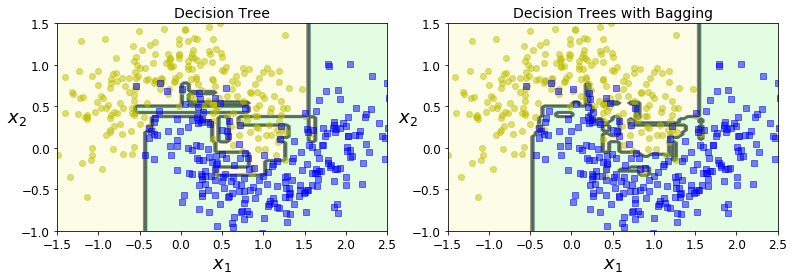

In [22]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. 

Overall, bagging often results in better models, which explains why it is generally preferred.

## Out of Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 
**By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set**


This means that only about 63% of the training instances are sampled on average for each predictor. 
**As m grows, this ratio approaches 1 – exp(–1) ≈ 63.212%.**
The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.


**Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an
automatic oob evaluation after training. **

The following code demonstrates this. The resulting evaluation score is available through the **oob\_score\_** variable:

In [23]:
bag_clf = BaggingClassifier( 
    DecisionTreeClassifier(), 
    n_estimators=500,
    bootstrap=True, 
    random_state=42,
    n_jobs=-1, 
    oob_score=True)
bag_clf.fit(X_train, y_train) 
bag_clf.oob_score_

0.8986666666666666

In [24]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [25]:
bag_clf

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [26]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.35625   , 0.64375   ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97409326, 0.02590674],
       [0.7370892 , 0.2629108 ],
       [0.0049505 , 0.9950495 ],
       [0.75      , 0.25      ],
       [0.82681564, 0.17318436],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.34502924, 0.65497076],
       [0.91666667, 0.08333333],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65420561, 0.34579439],
       [0.

## Random Forests

In [27]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [28]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, oob_score=True, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [30]:
rnd_clf.oob_score_

0.9173333333333333

In [31]:
for e in rnd_clf.estimators_:
    yt = e.predict(X_test)
    print(accuracy_score(y_test, yt))

0.84
0.896
0.848
0.832
0.784
0.824
0.896
0.88
0.88
0.88
0.896
0.832
0.856
0.888
0.832
0.864
0.856
0.912
0.864
0.88
0.84
0.848
0.912
0.896
0.84
0.848
0.856
0.88
0.856
0.888
0.856
0.832
0.848
0.896
0.896
0.888
0.864
0.872
0.896
0.888
0.88
0.88
0.848
0.888
0.848
0.84
0.896
0.848
0.896
0.88
0.864
0.888
0.832
0.888
0.832
0.84
0.856
0.856
0.848
0.84
0.888
0.864
0.8
0.872
0.88
0.888
0.896
0.816
0.856
0.888
0.888
0.848
0.936
0.88
0.824
0.92
0.896
0.84
0.888
0.872
0.872
0.904
0.856
0.864
0.856
0.864
0.888
0.816
0.872
0.848
0.856
0.896
0.816
0.832
0.84
0.864
0.896
0.872
0.92
0.904
0.824
0.824
0.848
0.848
0.904
0.808
0.704
0.808
0.848
0.88
0.832
0.84
0.872
0.88
0.808
0.864
0.896
0.904
0.744
0.888
0.848
0.84
0.832
0.856
0.888
0.848
0.84
0.864
0.808
0.784
0.88
0.792
0.824
0.888
0.848
0.88
0.92
0.864
0.768
0.872
0.896
0.88
0.912
0.88
0.888
0.848
0.8
0.88
0.88
0.936
0.856
0.872
0.896
0.88
0.88
0.816
0.872
0.848
0.88
0.872
0.824
0.872
0.848
0.872
0.832
0.896
0.864
0.904
0.88
0.896
0.856
0.848
0.904
0.

In [32]:
accuracy_score(y_test, y_pred_rf)

0.912

In [33]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

In [34]:
rnd_clf.feature_importances_

array([0.42253629, 0.57746371])

In [35]:
rnd_clf.oob_score

True

### Extra Trees

In [36]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_clf = ExtraTreesClassifier(n_estimators=195, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_tree_clf.fit(X_train, y_train)
y_pred_extra_trees = extra_tree_clf.predict(X_test)

In [37]:
accuracy_score(y_pred_extra_trees, y_pred)

0.992

In [38]:
np.sum(y_pred == y_pred_extra_trees) / len(y_pred)

0.992

### Feature Importances

In [39]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [40]:
rnd_clf.feature_importances_


array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.


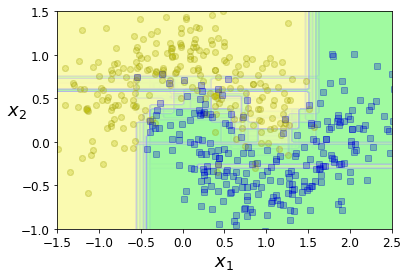

In [41]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [42]:
#from sklearn.datasets import fetch_mldata
#mnist = fetch_mldata('MNIST original')

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [43]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


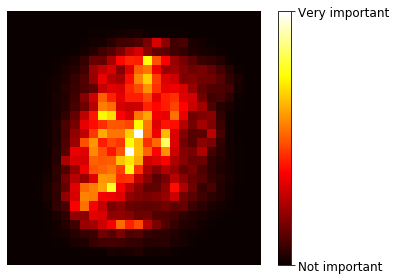

In [45]:

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## AdaBoost

In [46]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.


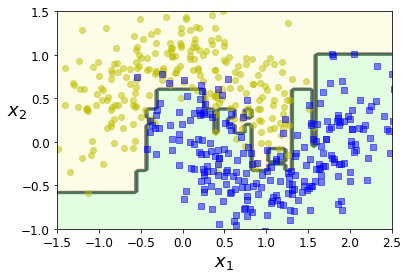

In [47]:
plot_decision_boundary(ada_clf, X, y)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'linewidth'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier insta

Saving figure boosting_plot


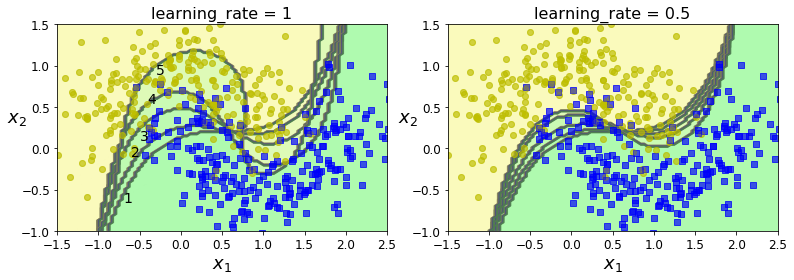

In [48]:
m = len(X_train)
plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
save_fig("boosting_plot")
plt.show()

In [49]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))


['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

## Gradient Boosting

In [50]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [52]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [53]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [54]:
3*0.3**2

0.27

In [55]:
X_new = np.array([[0.3]])
X_new

array([[0.3]])

In [56]:
y_pred_array = [tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)]
y_pred = sum(y_pred_array)
y_pred

array([0.17052257])

In [57]:
y_pred_array

[array([0.12356613]), array([0.03991297]), array([0.00704347])]

In [58]:
y_pred


array([0.17052257])

Saving figure gradient_boosting_plot


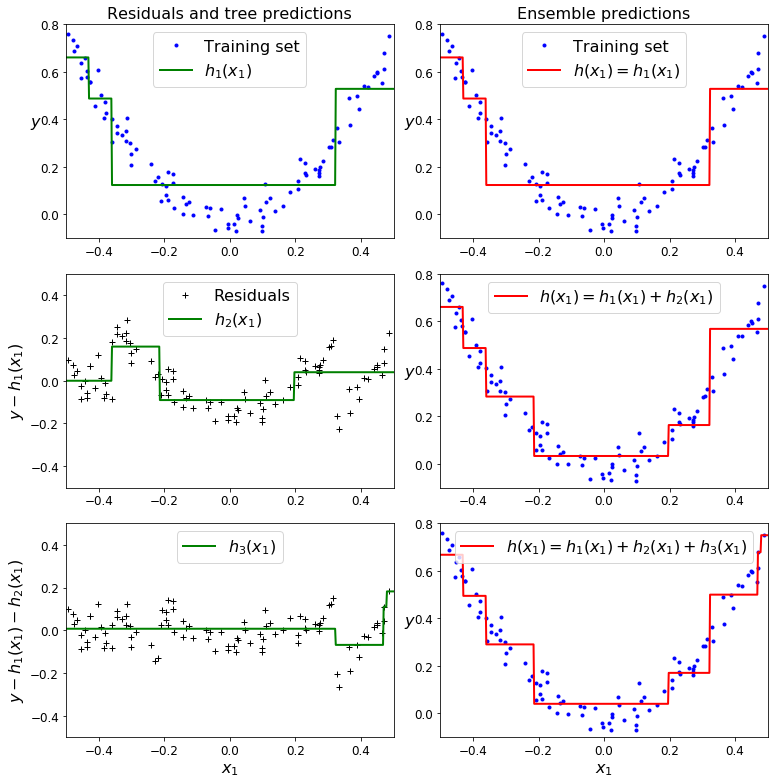

In [59]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
3*0.2**2

0.12000000000000002

In [62]:
gbrt.predict([[0.2]])

array([0.17052257])

In [63]:

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=29, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)
y_pred = gbrt_slow.predict(X)
gbrt_slow.loss_(y, y_pred) #MSE

0.0021618964019748618

In [65]:
GradientBoostingRegressor?

In [66]:
np.sum(np.square([y - y_pred])) / len(y)

0.0021618964019748618

In [67]:
gbrt_slow.loss_?

In [68]:
gbrt_slow.predict([[0.2]])

array([0.11642022])

In [69]:
for i, y_pred in enumerate(gbrt_slow.staged_predict(X)):
    x = gbrt_slow.loss_(y, y_pred)
    print(x)
    if x < 0.00216189640197:
        break;
    print(i)

0.04764465381991766
0
0.0403629889655186
1
0.03436807660288836
2
0.02940401879121217
3
0.02566408261649072
4
0.022030359115393198
5
0.019116061552538505
6
0.016534140874705915
7
0.014384068982595689
8
0.012583552023704479
9
0.011129489512017136
10
0.00997541340545445
11
0.00882675253304006
12
0.007933890138589328
13
0.007196407291525276
14
0.006563781847832413
15
0.006022596579032788
16
0.005403487547077464
17
0.004935743997108108
18
0.004480216393382758
19
0.0041511141327776405
20
0.0037661420830949273
21
0.0035033686563123185
22
0.003216775966133666
23
0.002904652648127405
24
0.002735944574608821
25
0.002593108629122235
26
0.002378188885128215
27
0.0021618964019748618
28


Saving figure gbrt_learning_rate_plot


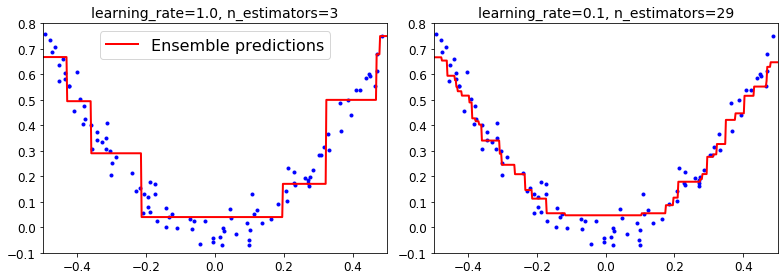

In [70]:

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

In [71]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=20, learning_rate=0.1, random_state=42, warm_start=True)

gbrt_slow.fit(X, y)
y_pred = gbrt_slow.predict(X)
print(gbrt_slow.loss_(y, y_pred))

gbrt_slow.fit(X, y)
y_pred = gbrt_slow.predict(X)

print(gbrt_slow.loss_(y, y_pred))

0.004480216393382758
0.004480216393382758


In [72]:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    print(n_estimators)
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            print("Stopping")
            break # early stopping

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
Stopping


### Gradient Boosting with early stopping



In [73]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
min_error = np.min(errors)


Saving figure early_stopping_gbrt_plot


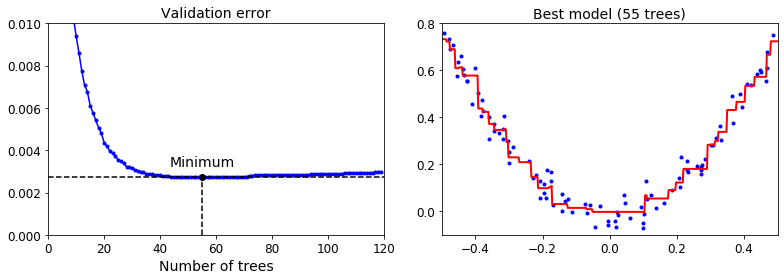

In [75]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

### Stacking

In [76]:
# Create Dataset
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, random_state=42)


In [77]:
# Train
log_clf_s = LogisticRegression(random_state=42)
rnd_clf_s = RandomForestClassifier(random_state=42)
svm_clf_s = SVC(random_state=42, probability=True)

rnd_clf_2 = RandomForestClassifier(random_state=42)

for p in [log_clf_s, rnd_clf_s, svm_clf_s]:
    p.fit(X_train_1, y_train_1)

log_clf_p = log_clf_s.predict(X_train_2)
rnd_clf_p = rnd_clf_s.predict(X_train_2)
svm_clf_p = svm_clf_s.predict(X_train_2)

held_out = np.column_stack((log_clf_p, rnd_clf_p, svm_clf_p))
rnd_clf_2.fit(held_out, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [78]:
# Predict

result_1 = []
for p in [log_clf_s, rnd_clf_s, svm_clf_s]:
    result_1.append(p.predict(X_test))

y_pred_s = rnd_clf_2.predict(np.column_stack(tuple(result_1)))
accuracy_score(y_test, y_pred_s)

0.896

In [79]:
np.column_stack(([1,2], [3,4], [5,6]))

array([[1, 3, 5],
       [2, 4, 6]])

## XGBoost

In [80]:
import numpy as np
from xgboost import XGBClassifier

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

#from sklearn.datasets import fetch_mldata
#mnist = fetch_mldata('MNIST original')

X, y = mnist["data"], mnist["target"]
shuffle_index = np.random.permutation(70000)
X, y = X[shuffle_index], y[shuffle_index]
X_train60, X_test, y_train60, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, y_train = X_train60[:5000], y_train60[:5000]

In [81]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

rf = RandomForestClassifier()
sgd = SGDClassifier()

rf.fit(X_train, y_train)
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
from sklearn.metrics import accuracy_score
y_predict = xgbc.predict(X_test)
rf_y_predict = rf.predict(X_test)
sgd_y_predict = sgd.predict(X_test)

print(" -- accuracy_score ---")
print(accuracy_score(y_test, y_predict))
print(accuracy_score(y_test, rf_y_predict))
print(accuracy_score(y_test, sgd_y_predict))

 -- accuracy_score ---
0.9228
0.9384
0.86


In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'learning_rate': [0.1, 0.3], 
     'min_child_weight': [0.5, 2], 'gamma': [0, 0.2], 'max_delta_step': [0], 'subsample': [1], 'colsample_bytree': [1], 'colsample_bylevel':[1], 'scale_pos_weight': [1]},]

xgbc_grid = XGBClassifier()
grid_search = GridSearchCV(xgbc_grid, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bylevel': [1], 'colsample_bytree': [1],
                          'gamma': [0, 0.2], 'learning_rate': [0.1, 0.3],
                          'max_delta_step': [0], 'min_child

### Alternative API - XGBoost

In [85]:

import xgboost as xgb
# read in data
dtrain = xgb.DMatrix('/cxldata/xgboost/agaricus.txt.train')
dtest = xgb.DMatrix('/cxldata/xgboost/agaricus.txt.test')
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

[14:38:22] 6513x127 matrix with 143286 entries loaded from /cxldata/xgboost/agaricus.txt.train
[14:38:22] 1611x127 matrix with 35442 entries loaded from /cxldata/xgboost/agaricus.txt.test


In [86]:
!head /cxldata/xgboost/agaricus.txt.train


1 3:1 10:1 11:1 21:1 30:1 34:1 36:1 40:1 41:1 53:1 58:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 117:1 124:1
0 3:1 10:1 20:1 21:1 23:1 34:1 36:1 39:1 41:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 106:1 116:1 120:1
0 1:1 10:1 19:1 21:1 24:1 34:1 36:1 39:1 42:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 106:1 116:1 122:1
1 3:1 9:1 19:1 21:1 30:1 34:1 36:1 40:1 42:1 53:1 58:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 117:1 124:1
0 3:1 10:1 14:1 22:1 29:1 34:1 37:1 39:1 41:1 54:1 58:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 98:1 106:1 114:1 120:1
0 3:1 9:1 20:1 21:1 23:1 34:1 36:1 39:1 42:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 116:1 120:1
0 1:1 10:1 19:1 21:1 23:1 34:1 36:1 39:1 45:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 116:1 122:1
1 3:1 9:1 19:1 21:1 30:1 34:1 36:1 40:1 48:1 53:1 58:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 118:1 120:1
0 1:1 10:1 20:1 21:1 23:1 34:1 36:1 39:1 45:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:

See more at https://xgboost.readthedocs.io/en/latest/python/python_intro.html